In [14]:
import math
import os
import sys
import random
import numpy as np
import torch
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torchvision.transforms as T
from source.cliploss import Loss
from source.beziercurve import CurveSet
from source.diffrasterizer import rasterize_spheres
from types import SimpleNamespace


In [3]:
%cd ..
%pwd

/home/alberts/Documents/EPFL/MA2/Visual_Intelligence/clipasso3d


/home/alberts/miniconda3/envs/3dsketch/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/alberts/Documents/EPFL/MA2/Visual_Intelligence/clipasso3d'

In [15]:
import math
import os
import sys
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (for 3d projection)
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import torchvision.transforms as T
from source.utils import load_scene

class ImageSampler:
    def __init__(
        self,
        transforms_json: str,
        image_dir: str,
        width: int,
        height: int,
        total_iters: int,
        device: str = "cuda",
    ):
        # 1. Load scene metadata
        file_paths, c2w_all, K = load_scene(transforms_json, width, height, device)
        self.device = device
        self.K = K.to(device)

        # 2. Store camera-to-world matrices
        self.c2w_all = c2w_all.to(device)  # (N,4,4)

        # 2a. Extract camera origins P and viewing directions N
        P = self.c2w_all[:, :3, 3]              # (N,3)
        N = -self.c2w_all[:, :3, 2]             # (N,3)

        # 2b. Compute scene center by least-squares intersection of camera rays
        # Solve: sum_i (I - N_i N_i^T) X = sum_i (I - N_i N_i^T) P_i
        I = torch.eye(3, device=P.device, dtype=P.dtype)
        A = torch.zeros((3, 3), device=P.device, dtype=P.dtype)
        b = torch.zeros((3,),    device=P.device, dtype=P.dtype)
        for i in range(P.shape[0]):
            n_i = N[i].unsqueeze(1)             # (3,1)
            M_i = I - n_i @ n_i.T               # (3,3)
            A += M_i
            b += (M_i @ P[i])
        # Solve linear system
        center = torch.linalg.solve(A, b)       # (3,)
        self.scene_center = center.cpu().numpy()

        # 2c. Precompute world-to-camera for rendering
        self.w2c_all = torch.linalg.inv(self.c2w_all)

        # 3. Preload & resize all images
        to_tensor = T.ToTensor()
        self.images = []
        for fp in file_paths:
            cleaned = fp.lstrip("./")
            rel_dir, stem = os.path.split(cleaned)
            base_dir = os.path.join(image_dir, rel_dir)

            # try common extensions
            for ext in [".png", ".jpg", ".jpeg"]:
                candidate = os.path.join(base_dir, stem + ext)
                if os.path.exists(candidate):
                    img = Image.open(candidate).convert("RGB")
                    break
            else:
                raise FileNotFoundError(
                    f"Could not find any of {stem} in {base_dir} with .png/.jpg/.jpeg"
                )

            t = to_tensor(img).unsqueeze(0).to(device)
            t = torch.nn.functional.interpolate(
                t, size=(height, width), mode="bilinear"
            )
            self.images.append(t)

        # 4. Build fixed schedule of length total_iters
        num_images = len(self.images)
        repeats = math.ceil(total_iters / num_images)
        schedule = torch.arange(num_images, device=device).repeat_interleave(repeats)
        self.schedule = schedule[:total_iters]

    def sample(self, it: int):
        """
        On iteration `it` return:
          - target_rgb: (1,3,H,W)
          - K:         (3,3)
          - w2c:       (4,4)
        """
        idx = int(self.schedule[it])
        return self.images[idx], self.K, self.w2c_all[idx]

    def plot_camera_poses(
        self,
        arrow_length: float = 0.5,
        cube_size: float = None
    ):
        """
        Plot 3D camera positions with view normals and optional cube.

        Args:
            arrow_length: arrow length for view normals.
            cube_size: if set, draws a cube of side cube_size whose center sits
                       at the computed scene_center.
        Returns:
            fig, ax: Matplotlib Figure and 3D Axes.
        """
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Plot camera origins
        pos = self.c2w_all[:, :3, 3].cpu().numpy()
        ax.scatter(pos[:,0], pos[:,1], pos[:,2], c='red', s=30, label='Cameras')

        # Plot view normals
        normals = -self.c2w_all[:, :3, 2].cpu().numpy()
        for p, n in zip(pos, normals):
            ax.quiver(
                p[0], p[1], p[2],
                n[0], n[1], n[2],
                length=arrow_length, normalize=True,
                color='blue', linewidth=1
            )

        # Draw cube at scene_center
        if cube_size is not None:
            cx, cy, cz = self.scene_center
            half = cube_size / 2.0
            vertices = np.array([
                [cx-half, cy-half, cz-half],
                [cx+half, cy-half, cz-half],
                [cx+half, cy+half, cz-half],
                [cx-half, cy+half, cz-half],
                [cx-half, cy-half, cz+half],
                [cx+half, cy-half, cz+half],
                [cx+half, cy+half, cz+half],
                [cx-half, cy+half, cz+half],
            ])
            faces = [
                [0,1,2,3], [4,5,6,7],
                [0,1,5,4], [1,2,6,5],
                [2,3,7,6], [3,0,4,7]
            ]
            face_verts = [[vertices[idx] for idx in face] for face in faces]
            poly = Poly3DCollection(face_verts, alpha=0.3, facecolor='cyan', edgecolor='k', label='Object')
            ax.add_collection3d(poly)

        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        ax.set_title('Scene Setup')
        ax.legend()

        # Equal aspect
        max_range = (pos.max(axis=0) - pos.min(axis=0)).max() / 2.0
        mid = pos.mean(axis=0)
        ax.set_xlim(mid[0]-max_range, mid[0]+max_range)
        ax.set_ylim(mid[1]-max_range, mid[1]+max_range)
        ax.set_zlim(mid[2]-max_range, mid[2]+max_range)

        plt.show()
        return fig, ax

In [21]:
# --- Settings ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
width, height = 224, 224
batch_size = 1
epochs = 10
inner_steps = 30
thickness = 0.005
learning_rate = 0.010
save_dir = Path('training_frames')
save_dir.mkdir(exist_ok=True)



In [22]:
# --- Prepare data sampler for a single scene ---
data_name = 'chair'
transforms_json = "data/{}/transforms_train.json".format(data_name)
image_dir = 'data/{}'.format(data_name)
sampler = ImageSampler(
    transforms_json=transforms_json,
    image_dir=image_dir,
    width=width,
    height=height,
    total_iters=0,  # unused in random sampling
    device=device,
)


In [23]:

# --- Prepare loss and rasterizer ---
args = SimpleNamespace(
    device=device,
    percep_loss='none',
    train_with_clip=True,
    clip_weight=1.0,
    start_clip=0,
    clip_conv_loss=1,
    clip_fc_loss_weight=0.1,
    clip_text_guide=0.0,
    num_aug_clip=4,
    augemntations=['affine'],
    include_target_in_aug=False,
    augment_both=False,
    clip_model_name='ViT-B/32',
    clip_conv_loss_type='L2',
    clip_conv_layer_weights=[0.5, 2.0, 1.2, 1.0, 0.0]
)
criterion = Loss(args).to(device)
rasterizer = torch.compile(rasterize_spheres)

In [24]:
# --- Initialize curves as short lines at random locations on a sphere ---
def random_short_lines(center: torch.Tensor,
                       n_curves: int,
                       radius: float,
                       length: float,
                       device: str):
    """
    center: (3,) origin of the sphere
    n_curves: how many line‐curves to make
    radius:  how far from center to place each line
    length:  total length of each line segment
    """
    lines = []
    for _ in range(n_curves):
        # 1) Pick a random point ON the sphere
        dir_loc = torch.randn(3, device=device)
        dir_loc = dir_loc / dir_loc.norm()
        loc = center + radius * dir_loc       # (3,)

        # 2) Pick a random line direction orthogonal to dir_loc
        dir_line = torch.randn(3, device=device)
        dir_line = dir_line - (dir_line @ dir_loc) * dir_loc
        dir_line = dir_line / dir_line.norm()

        # 3) Build 4 control points along that line of total length `length`
        offsets = torch.tensor([-0.5, -0.1667, 0.1667, 0.5],
                               device=device) * length  # (4,)
        ctrl_pts = loc[None] + offsets[:, None] * dir_line[None]  # (4,3)

        lines.append(ctrl_pts)
    return lines

# Convert numpy center to torch
center_t = torch.tensor(sampler.scene_center,
                        device=device, dtype=torch.float32)

# Parameters
n_curves = 10
radius   = 0.5    # how far out to place each line from center
length   = 0.01    # how long each line is

# Generate
init_pts = random_short_lines(center_t, n_curves, radius, length, device)

# Create & optimize
curve_set = CurveSet(init_pts,
                     thickness=thickness,
                     overlap=0.6,
                     arc_samples=300,
                     device=device).to(device)
optimizer = optim.Adam(curve_set.parameters(), lr=learning_rate)

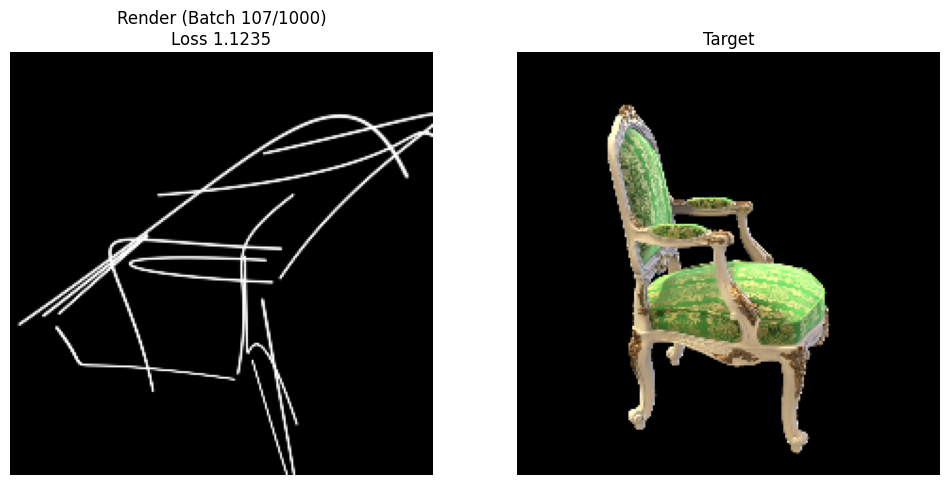

KeyboardInterrupt: 

In [25]:
# --- Setup display as 1×2 subplots ---
plt.ioff()
fig, (ax_render, ax_target) = plt.subplots(1, 2, figsize=(12, 6))

# placeholder for the render
im_render = ax_render.imshow(
    torch.zeros((height, width, 3), dtype=torch.float32).numpy(),
    vmin=0, vmax=1
)
ax_render.set_title("Render")
ax_render.axis('off')

# placeholder for the target
# assume the very first sample shows its target
first_target = sampler.images[0][0].permute(1,2,0).cpu().numpy()
im_target = ax_target.imshow(first_target, vmin=0, vmax=1)
ax_target.set_title("Target")
ax_target.axis('off')

# --- Training loop (multi‐step per batch) ---
N_views          = len(sampler.images)
updates_per_epoch= math.ceil(N_views / batch_size)
total_batches    = updates_per_epoch * epochs

for batch_idx in range(total_batches):
    # 1) sample a fresh batch of views
    batch_data = []
    for _ in range(batch_size):
        v_idx = random.randrange(N_views)
        batch_data.append((
            sampler.images[v_idx],      # target_rgb (1,3,H,W)
            sampler.K,                  # K
            sampler.w2c_all[v_idx]      # world‐to‐camera
        ))

    # 2) take `inner_steps` gradient updates on this same batch
    for inner in range(inner_steps):
        optimizer.zero_grad()
        losses = []
        for target_rgb, K, w2c in batch_data:
            means, thicknesses = curve_set()
            img = rasterizer(means, thicknesses, w2c, K, width, height)
            img = img.permute(2,0,1).unsqueeze(0).repeat(1,3,1,1)
            it = batch_idx * inner_steps + inner
            losses.append(criterion(img, target_rgb, it))
        loss = torch.stack(losses).mean()
        loss.backward()
        optimizer.step()

    # after inner steps, display both render and its corresponding target
    # take the *last* rendered img and the *first* target in batch_data as example
    render_np = img[0].permute(1,2,0).detach().cpu().numpy()
    target_np = batch_data[0][0][0].permute(1,2,0).cpu().numpy()

    im_render.set_data(render_np)
    im_target.set_data(target_np)

    ax_render.set_title(
        f"Render (Batch {batch_idx}/{total_batches})\nLoss {loss.item():.4f}"
    )
    ax_target.set_title("Target")

    fig.canvas.draw()
    fig.savefig(save_dir / f'batch_{batch_idx:04d}.png',
                bbox_inches='tight', pad_inches=0)
    clear_output(wait=True)
    display(fig)

plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_spheres_matplotlib(
    means: np.ndarray,
    radii: np.ndarray,
    resolution: int = 20,
    alpha: float = 0.6,
    colormap: str = "viridis"
):
    """
    Plot 3D spheres centered at `means` with given `radii`, using Matplotlib.

    Args:
        means      (N,3) numpy array of sphere centers
        radii      (N,)  numpy array of sphere radii
        resolution number of subdivisions in θ,ϕ (higher → smoother)
        alpha      transparency of each sphere
        colormap   name of a matplotlib colormap for coloring spheres
    """
    # parameterize a unit sphere
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    uu, vv = np.meshgrid(u, v)

    fig = plt.figure(figsize=(5, 5),dpi = 600)
    ax = fig.add_subplot(111, projection="3d")

    cmap = plt.get_cmap(colormap)
    N = len(means)

    for i, ((x0, y0, z0), r) in enumerate(zip(means, radii)):
        # compute sphere surface
        x = x0 + r * np.cos(uu) * np.sin(vv)
        y = y0 + r * np.sin(uu) * np.sin(vv)
        z = z0 + r * np.cos(vv)

        # pick a color from the colormap
        color = cmap(i / max(1, N - 1))  # RGBA tuple
        # now build a (res,res,4) array of that color
        fc = np.broadcast_to(np.array(color)[None, None, :], x.shape + (4,))

        ax.plot_surface(
            x, y, z,
            rstride=1, cstride=1,
            facecolors=fc,
            edgecolor='k',    # draw black edges
            linewidth=0.2,    # thin lines
            shade=True,
            alpha=alpha
        )

    # equal aspect ratio
    xyz = np.vstack([means + radii[:, None], means - radii[:, None]])
    x_limits = (xyz[:, 0].min(), xyz[:, 0].max())
    y_limits = (xyz[:, 1].min(), xyz[:, 1].max())
    z_limits = (xyz[:, 2].min(), xyz[:, 2].max())
    max_range = np.array([
        x_limits[1] - x_limits[0],
        y_limits[1] - y_limits[0],
        z_limits[1] - z_limits[0],
    ]).max() / 2.0

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    #ax.set_xlim(mid_x - max_range, mid_x + max_range)
    #ax.set_ylim(mid_y - max_range, mid_y + max_range)
    #ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.grid(False)

    plt.tight_layout()
    plt.savefig("3D_spheres_plot.png", dpi=600)
    plt.show()

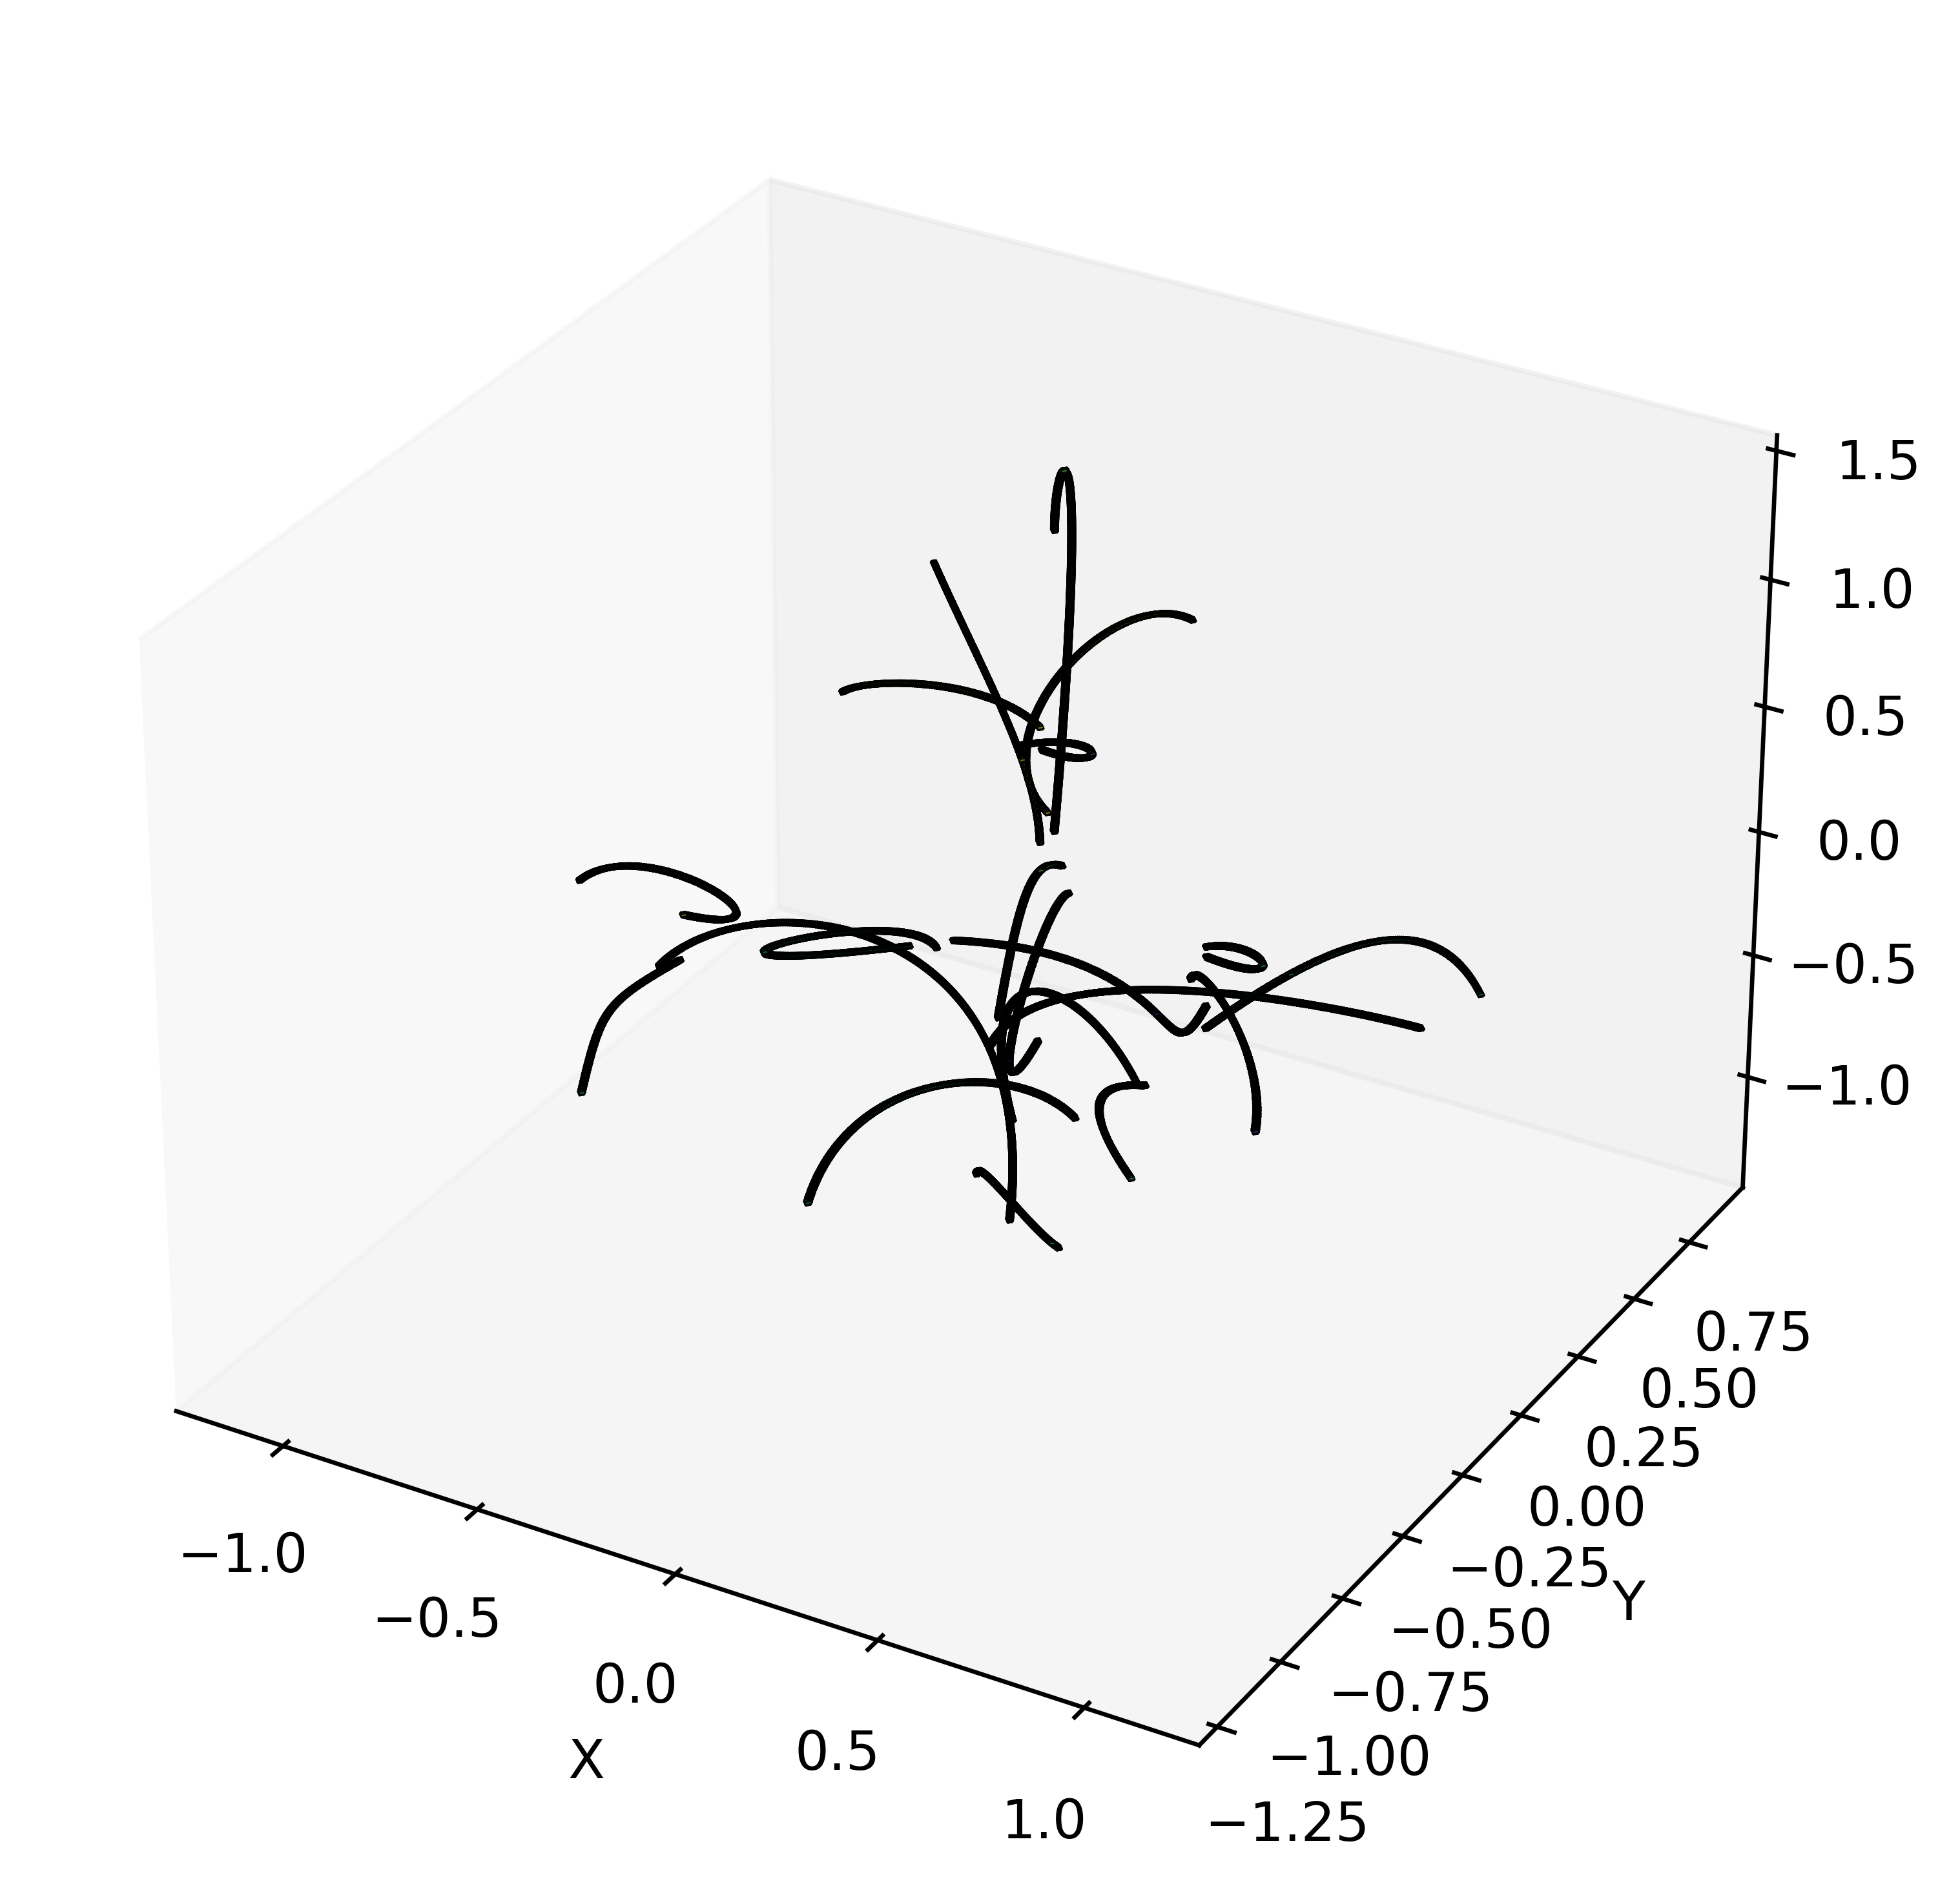

In [21]:
means_np = means.detach().cpu().numpy()
radii_np = thicknesses.detach().cpu().numpy()
plot_spheres_matplotlib(means_np, radii_np*2, resolution=5, alpha=1.0)

In [14]:
from PIL import Image as PILImage

# Gather and sort saved frames
frame_paths = sorted(save_dir.glob("batch_*.png"))
frames = [PILImage.open(p) for p in frame_paths]

# Save GIF
gif_path = "training_evolution.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=50, loop=0)
print(f"GIF saved to {gif_path}")

GIF saved to training_evolution.gif
